In [1]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
# Valeria Quiroz  - Gabriel Zapata
%%time
!pip install kaggle
api_token = {"username":"gabrielzapata","key":"45d11139cb4e32995898eae373213b5f"}
import json
import zipfile
import os
with open('/content/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!mkdir /root/.kaggle      
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v/content
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c ga-customer-revenue-prediction
if not os.path.exists("/content/competitions/ga-customer-revenue-prediction"):
    os.makedirs("/content/competitions/ga-customer-revenue-prediction")
os.chdir('/content/competitions/ga-customer-revenue-prediction')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

- path is now set to: /content
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 86.4MB/s]
 96% 5.00M/5.23M [00:00<00:00, 39.1MB/s]
100% 5.23M/5.23M [00:00<00:00, 33.5MB/s]
 95% 58.0M/61.1M [00:00<00:00, 58.4MB/s]
100% 61.1M/61.1M [00:00<00:00, 74.0MB/s]
100% 1.11G/1.11G [00:14<00:00, 84.0MB/s]
100% 1.11G/1.11G [00:14<00:00, 84.2MB/s]
 88% 50.0M/56.8M [00:00<00:00, 40.1MB/s]
100% 56.8M/56.8M [00:01<00:00, 58.6MB/s]
 97% 324M/333M [00:03<00:00, 76.3MB/s]
100% 333M/333M [00:04<00:00, 82.8MB/s]
CPU times: user 1min 51s, sys: 38.5 s, total: 2min 29s
Wall time: 7min 42s


### **Librerias**

In [2]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); init.get_weblink() 

replicating local resources


In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from pandas import json_normalize
import seaborn as sns 
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
import plotly.graph_objs as go
from plotly import subplots
import plotly.offline as py
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import datetime
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold,KFold,RepeatedKFold
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, RepeatVector, TimeDistributed, LSTM, GRU
import numpy as np
import tensorflow as tf,keras    
from tensorflow.keras.models import Sequential  

#from sklearn.metrics import mean_absolute_percentage_error

In [4]:
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, RepeatVector, TimeDistributed, LSTM, GRU
import numpy as np
import tensorflow as tf,keras    
from tensorflow.keras.models import Sequential

In [5]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

setting tensorflow version in colab


'2.4.1'

### **Explicacion del codigo json sacado de Kaggle, para aplanar los datos**

In [6]:
def load_df(csv_path='/content/competitions/ga-customer-revenue-prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [7]:
%%time
train_df = load_df()
#test_df = load_df('/content/competitions/ga-customer-revenue-prediction/test.csv')

Loaded train.csv. Shape: (903653, 55)
CPU times: user 2min 12s, sys: 8.43 s, total: 2min 20s
Wall time: 2min 23s


In [8]:
train_df = train_df.drop( ['sessionId'] + ["trafficSource.campaignCode"], axis=1)
print(train_df.shape)

(903653, 53)


### **Eliminemos columnas constantes e imputar valores cero a NAN**

In [9]:
print ("Antes de eliminar columnas constantes - shape de train y test datasets: ", train_df.shape)
train_df = train_df.loc[:, (train_df != train_df.iloc[0]).any()]
print ("Despues de eliminar columnas constantes - shape de train y test datasets: ", train_df.shape)

Antes de eliminar columnas constantes - shape de train y test datasets:  (903653, 53)
Despues de eliminar columnas constantes - shape de train y test datasets:  (903653, 34)


In [10]:
# Replace NaN values throughout train dataset
train_df.replace(to_replace=np.nan, value=0, inplace=True)

### **Conversion variable categórica a númerica**

In [11]:
# etiqueta codifica las variables categóricas y convierte las variables numéricas flotantes
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", "device.isMobile",
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    


num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
   

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
device.isMobile
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [12]:
train_df.to_csv('dataset.csv')

In [13]:
train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))###Cambia el formato de la fecha

In [14]:
Y = train_df["totals.transactionRevenue"].astype('float')
X=train_df.drop(["totals.transactionRevenue"],axis=1)##Eliminamos la salida de los datos de las caracteristicas


In [15]:
##==================###Fold1######============================
Fold1 = train_df[train_df['date']<=datetime.date(2016,11,1)]
train1=Fold1[Fold1['date']<=datetime.date(2016,9,15)]
Val1=Fold1[Fold1['date']>datetime.date(2016,9,15)]

##==================###Fold2######============================
Foldt = train_df[train_df['date']>datetime.date(2016,11,1)]
Fold2 = Foldt[Foldt['date']<=datetime.date(2017,2,1)]
train2=Fold2[Fold2['date']<=datetime.date(2016,12,15)]
Val2=Fold2[Fold2['date']>datetime.date(2016,12,15)]

##==================###Fold3######============================
Foldt2 = train_df[train_df['date']>datetime.date(2017,2,1)]
Fold3 = Foldt2[Foldt2['date']<=datetime.date(2017,5,1)]
train3=Fold3[Fold3['date']<=datetime.date(2017,3,15)]
Val3=Fold3[Fold3['date']>datetime.date(2017,3,15)]

##===================#####All Train#######====================
X_Train=train_df[train_df['date']<=datetime.date(2017,5,1)]
Y_Train=np.log1p(X_Train["totals.transactionRevenue"].astype('float'))

##======================####Test#####==========================
Test = train_df[train_df['date']>datetime.date(2017,5,1)]
y_test= np.log1p(Test["totals.transactionRevenue"].astype('float'))
X_test=Test.drop(["totals.transactionRevenue"],axis=1)

In [16]:
dev_y1 = np.log1p(train1["totals.transactionRevenue"].astype('float'))
val_y1 = np.log1p(Val1["totals.transactionRevenue"].astype('float'))
dev_y2 = np.log1p(train2["totals.transactionRevenue"].astype('float'))
val_y2 = np.log1p(Val2["totals.transactionRevenue"].astype('float'))
dev_y3 = np.log1p(train3["totals.transactionRevenue"].astype('float'))
val_y3 = np.log1p(Val3["totals.transactionRevenue"].astype('float'))

In [17]:
X_Train=X_Train.drop(["totals.transactionRevenue"],axis=1)
train1=train1.drop(["totals.transactionRevenue"],axis=1)
train2=train2.drop(["totals.transactionRevenue"],axis=1)
train3=train3.drop(["totals.transactionRevenue"],axis=1)
Val1=Val1.drop(["totals.transactionRevenue"],axis=1)
Val2=Val2.drop(["totals.transactionRevenue"],axis=1)
Val3=Val3.drop(["totals.transactionRevenue"],axis=1)

no eliminar hasta probar

In [18]:
X_Train=X_Train.drop(["date"],axis=1)
train1=train1.drop(["date"],axis=1)
train2=train2.drop(["date"],axis=1)
train3=train3.drop(["date"],axis=1)
Val1=Val1.drop(["date"],axis=1)
Val2=Val2.drop(["date"],axis=1)
Val3=Val3.drop(["date"],axis=1)
X_test=X_test.drop(["date"],axis=1)

In [19]:
######Convesor a tensor######
def Conv2tensor(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

In [20]:
#_________________________Train_____________________________________
traint1=Conv2tensor(train1)
traint2=Conv2tensor(train2)
traint3=Conv2tensor(train3)
dev_yt1=Conv2tensor(dev_y1)
dev_yt2=Conv2tensor(dev_y2)
dev_yt3=Conv2tensor(dev_y3)
#_________________________Validacion_________________________________
Valt1=Conv2tensor(Val1)
Valt2=Conv2tensor(Val2)
Valt3=Conv2tensor(Val3)
val_yt1=Conv2tensor(val_y1)
val_yt2=Conv2tensor(val_y2)
val_yt3=Conv2tensor(val_y3)
#_________________________X_test_____________________________________
X_testt=Conv2tensor(X_test)
y_testt=Conv2tensor(y_test)

In [21]:
def model1(Neuronas=32 ,dropout=0.1 ,Acti='relu'):
    model = Sequential()
    model.add(Dense(Neuronas, input_dim=32, activation=Acti))
    model.add(Dropout(dropout))
    model.add(Dense(Neuronas, activation=Acti))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation ='sigmoid'))
    model.compile(optimizer='Adam',loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
    return model

In [ ]:
num_cell=[64,128,256,512,1028,2048]
Drop=[0.1,0.3,0.5,0.7,0.9]
Act=['relu','tanh','sigmoid', 'linear']
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode = 'auto',restore_best_weights = True)
TrainError1=[]
for num in num_cell:
     for drop in Drop:
         for act in Act:
              model1(num, drop, act)
              estimator = KerasRegressor(build_fn=model1)
              #HistoryTrain=estimator.fit(traint1,dev_yt1,callbacks=[callback],batch_size=0,epochs=20,verbose=1) 
              HistoryTrain1 =estimator.fit(traint1,dev_yt1,batch_size=800,epochs=20,validation_data=(Valt1, val_yt1),verbose=2)
              pred_test_y = estimator.predict(Valt1)
              pred_test_y[pred_test_y<0]=0
              RMSE=np.sqrt(metrics.mean_squared_error(val_y1,pred_test_y))
              MAE=metrics.mean_absolute_error(val_y1,pred_test_y)
              TrainError1.append([act,num,drop,HistoryTrain.history,RMSE,MAE])

Epoch 1/20
138/138 - 1s - loss: 4.5852 - root_mean_squared_error: 2.1413 - mean_absolute_error: 0.2880 - val_loss: 3.1398 - val_root_mean_squared_error: 1.7719 - val_mean_absolute_error: 0.1751
Epoch 2/20
138/138 - 1s - loss: 4.5860 - root_mean_squared_error: 2.1415 - mean_absolute_error: 0.2871 - val_loss: 3.1398 - val_root_mean_squared_error: 1.7719 - val_mean_absolute_error: 0.1751
Epoch 3/20
138/138 - 1s - loss: 4.5860 - root_mean_squared_error: 2.1415 - mean_absolute_error: 0.2869 - val_loss: 3.1398 - val_root_mean_squared_error: 1.7719 - val_mean_absolute_error: 0.1751
Epoch 4/20
138/138 - 1s - loss: 4.5859 - root_mean_squared_error: 2.1415 - mean_absolute_error: 0.2879 - val_loss: 3.1398 - val_root_mean_squared_error: 1.7719 - val_mean_absolute_error: 0.1751
Epoch 5/20
138/138 - 1s - loss: 4.5877 - root_mean_squared_error: 2.1419 - mean_absolute_error: 0.2877 - val_loss: 3.1398 - val_root_mean_squared_error: 1.7719 - val_mean_absolute_error: 0.1751
Epoch 6/20
138/138 - 1s - loss

In [ ]:
plt.plot(HistoryTrain1.history['loss'])

In [42]:
TrainError2=[]
for num in num_cell:
     for drop in Drop:
         for act in Act:
              model1(num, drop, act)
              estimator = KerasRegressor(build_fn=model1)
              HistoryTrain2=estimator.fit(traint2,dev_yt2,callbacks=[callback],batch_size=800,epochs=20,verbose=0) 
              pred_test_y = estimator.predict(Valt2)
              pred_test_y[pred_test_y<0]=0
              RMSE=np.sqrt(metrics.mean_squared_error(val_y2,pred_test_y))
              MAE=metrics.mean_absolute_error(val_y2,pred_test_y)
              TrainError2.append([act,num,drop,HistoryTrain2.history,RMSE,MAE])

In [ ]:
plt.plot(HistoryTrain2.history['loss'])

In [43]:
TrainError3=[]
for num in num_cell:
     for drop in Drop:
         for act in Act:
              model1(num, drop, act)
              estimator = KerasRegressor(build_fn=model1)
              HistoryTrain3=estimator.fit(traint3,dev_yt3,callbacks=[callback],batch_size=800,epochs=20,verbose=0) 
              pred_test_y = estimator.predict(Valt3)
              pred_test_y[pred_test_y<0]=0
              RMSE=np.sqrt(metrics.mean_squared_error(val_y3,pred_test_y))
              MAE=metrics.mean_absolute_error(val_y3,pred_test_y)
              TrainError3.append([act,num,drop,HistoryTrain3.history,RMSE,MAE])

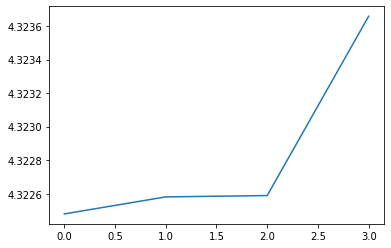

In [50]:
plt.plot(HistoryTrain3.history['loss'])

In [51]:
HistoryTrain.history

{'loss': [4.322479248046875,
  4.322580814361572,
  4.322588920593262,
  4.3236589431762695],
 'mean_absolute_error': [1.1812963485717773,
  1.1815547943115234,
  1.1814252138137817,
  1.1818453073501587],
 'root_mean_squared_error': [2.079057216644287,
  2.0790817737579346,
  2.0790836811065674,
  2.079340934753418]}

In [44]:
dfEstimadoresError=pd.DataFrame({'Modelo1' :TrainError1,'Modelo2' :TrainError2,'Modelo3' :TrainError3})
dfEstimadoresError.to_csv('EstimadoresError.csv')

In [45]:
dfEstimadoresError

,Modelo1,Modelo2,Modelo3
0,"[relu, 64, 0.1, {'loss': [5.0583343505859375, ...","[relu, 64, 0.1, {'loss': [3.675349235534668, 3...","[relu, 64, 0.1, {'loss': [4.318558692932129, 4..."
1,"[tanh, 64, 0.1, {'loss': [5.059696197509766, 5...","[tanh, 64, 0.1, {'loss': [4.11756706237793, 4....","[tanh, 64, 0.1, {'loss': [3.7541074752807617, ..."
2,"[sigmoid, 64, 0.1, {'loss': [5.026223182678223...","[sigmoid, 64, 0.1, {'loss': [4.139974594116211...","[sigmoid, 64, 0.1, {'loss': [4.209365367889404..."
3,"[linear, 64, 0.1, {'loss': [4.675378322601318,...","[linear, 64, 0.1, {'loss': [3.613528251647949,...","[linear, 64, 0.1, {'loss': [4.292636394500732,..."
4,"[relu, 64, 0.3, {'loss': [5.047526836395264, 5...","[relu, 64, 0.3, {'loss': [3.580704927444458, 3...","[relu, 64, 0.3, {'loss': [3.760850429534912, 3..."
...,...,...,...
115,"[linear, 2048, 0.7, {'loss': [4.56843090057373...","[linear, 2048, 0.7, {'loss': [3.58613443374633...","[linear, 2048, 0.7, {'loss': [4.25158262252807..."
116,"[relu, 2048, 0.9, {'loss': [4.571390151977539,...","[relu, 2048, 0.9, {'loss': [3.9522809982299805...","[relu, 2048, 0.9, {'loss': [3.8730812072753906..."
117,"[tanh, 2048, 0.9, {'loss': [5.052127361297607,...","[tanh, 2048, 0.9, {'loss': [3.578307628631592,...","[tanh, 2048, 0.9, {'loss': [4.0242462158203125..."
118,"[sigmoid, 2048, 0.9, {'loss': [4.5778522491455...","[sigmoid, 2048, 0.9, {'loss': [4.1305956840515...","[sigmoid, 2048, 0.9, {'loss': [4.2831187248229..."


In [46]:
RMSE1=[]
MAE1=[]
act=[]
num_cell=[]
drop=[]
l=1
m=1
for i in range(len(TrainError1)):
    mse=(TrainError1[i][4]+TrainError2[i][4]+TrainError3[i][4])/3
    mae=(TrainError1[i][5]+TrainError2[i][5]+TrainError3[i][5])/3
    RMSE1.append(mse)
    MAE1.append(mae)
    act.append(TrainError1[i][0])
    num_cell.append(TrainError1[i][1])
    drop.append(TrainError1[i][2])

In [47]:
Totaldf1EstimadoresError=pd.DataFrame({'act': act,'num_cell':num_cell,'drop':drop,'RMSE1' :RMSE1,'MAE1' :MAE1,})
Totaldf1EstimadoresError.to_csv('TotalEstimadoresError.csv')

In [48]:
Totaldf1EstimadoresError[Totaldf1EstimadoresError['MAE1']==Totaldf1EstimadoresError['MAE1'].min()]

,act,num_cell,drop,RMSE1,MAE1
21,tanh,128,0.1,1.961521,0.215992
23,linear,128,0.1,1.961521,0.215992
43,linear,256,0.1,1.961521,0.215992
70,sigmoid,512,0.5,1.961521,0.215992
77,tanh,512,0.9,1.961521,0.215992
81,tanh,1028,0.1,1.961521,0.215992
82,sigmoid,1028,0.1,1.961521,0.215992
83,linear,1028,0.1,1.961521,0.215992
84,relu,1028,0.3,1.961521,0.215992
89,tanh,1028,0.5,1.961521,0.215992


In [49]:
Totaldf1EstimadoresError[Totaldf1EstimadoresError['RMSE1']==Totaldf1EstimadoresError['RMSE1'].min()]

,act,num_cell,drop,RMSE1,MAE1
21,tanh,128,0.1,1.961521,0.215992
23,linear,128,0.1,1.961521,0.215992
43,linear,256,0.1,1.961521,0.215992
70,sigmoid,512,0.5,1.961521,0.215992
77,tanh,512,0.9,1.961521,0.215992
81,tanh,1028,0.1,1.961521,0.215992
82,sigmoid,1028,0.1,1.961521,0.215992
83,linear,1028,0.1,1.961521,0.215992
84,relu,1028,0.3,1.961521,0.215992
89,tanh,1028,0.5,1.961521,0.215992
